<a href="https://colab.research.google.com/github/bindhu520/Crime-Prediction-Analysis/blob/main/Crime_PredictionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import itertools

import pandas as pd
import pandas.util.testing as tm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.metrics import r2_score
from prophet import Prophet

In [ ]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (30,6)
matplotlib.rcParams['axes.titlesize']= 20

In [ ]:
def mapperDictGenerator(df, label):
  d= dict()
  factorized= pd.factorize(df[label])
  for i, _ in enumerate(factorized[1]):
    d[i]= _
  return factorized[0], d

In [ ]:
df=pd.read_csv('/content/sample_data/MCI_2014_to_2019.csv')
df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,3.0,Assault,D14,79.0,University (79),-79.405228,43.656982,7001.0
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,...,227.0,Saturday,21.0,Assault,D42,118.0,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002.0
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,...,228.0,Sunday,16.0,Break and Enter,D43,137.0,Woburn (137),-79.225029,43.765942,7003.0
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,...,330.0,Thursday,13.0,Break and Enter,D43,133.0,Centennial Scarborough (133),-79.140823,43.778648,7004.0
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,19.0,Assault,D55,61.0,Taylor-Massey (61),-79.288361,43.691235,7005.0


In [ ]:
df.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Hood_ID,Long,Lat,ObjectId
count,44668.000000,44668.000000,44668.000000,44668.000000,44668.000000,44668.000000,44668.000000,44668.000000,44667.000000,44641.000000,44641.000000,44641.000000,44667.000000,44667.000000,44667.000000,44667.000000,44667.000000
mean,-79.388887,43.707210,23507.556842,1645.645876,139.145205,2014.479627,15.702382,187.329699,13.004321,2014.442732,15.497525,186.682265,12.312222,74.234939,-79.388889,43.707209,23505.670361
std,0.103335,0.052635,14490.975679,301.687531,49.698712,0.499590,8.849876,102.205101,6.811314,0.640023,8.974019,102.582332,7.177955,40.194951,0.103335,0.052635,14488.260102
min,-79.634934,43.587093,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,1.000000,-79.634934,43.587093,1.000000
25%,-79.460520,43.661291,11167.750000,1430.000000,100.000000,2014.000000,8.000000,103.000000,8.000000,2014.000000,8.000000,102.000000,7.000000,40.000000,-79.460529,43.661285,11167.500000
50%,-79.388641,43.700161,22334.500000,1430.000000,100.000000,2014.000000,16.000000,189.000000,14.000000,2014.000000,16.000000,189.000000,13.000000,76.000000,-79.388641,43.700161,22334.000000
75%,-79.310112,43.751804,35501.250000,2120.000000,200.000000,2015.000000,23.000000,274.000000,19.000000,2015.000000,23.000000,274.000000,18.000000,111.000000,-79.310112,43.751804,35500.500000
max,-79.123100,43.847012,51000.000000,2133.000000,230.000000,2015.000000,31.000000,365.000000,23.000000,2015.000000,31.000000,366.000000,23.000000,140.000000,-79.123100,43.847012,51000.000000


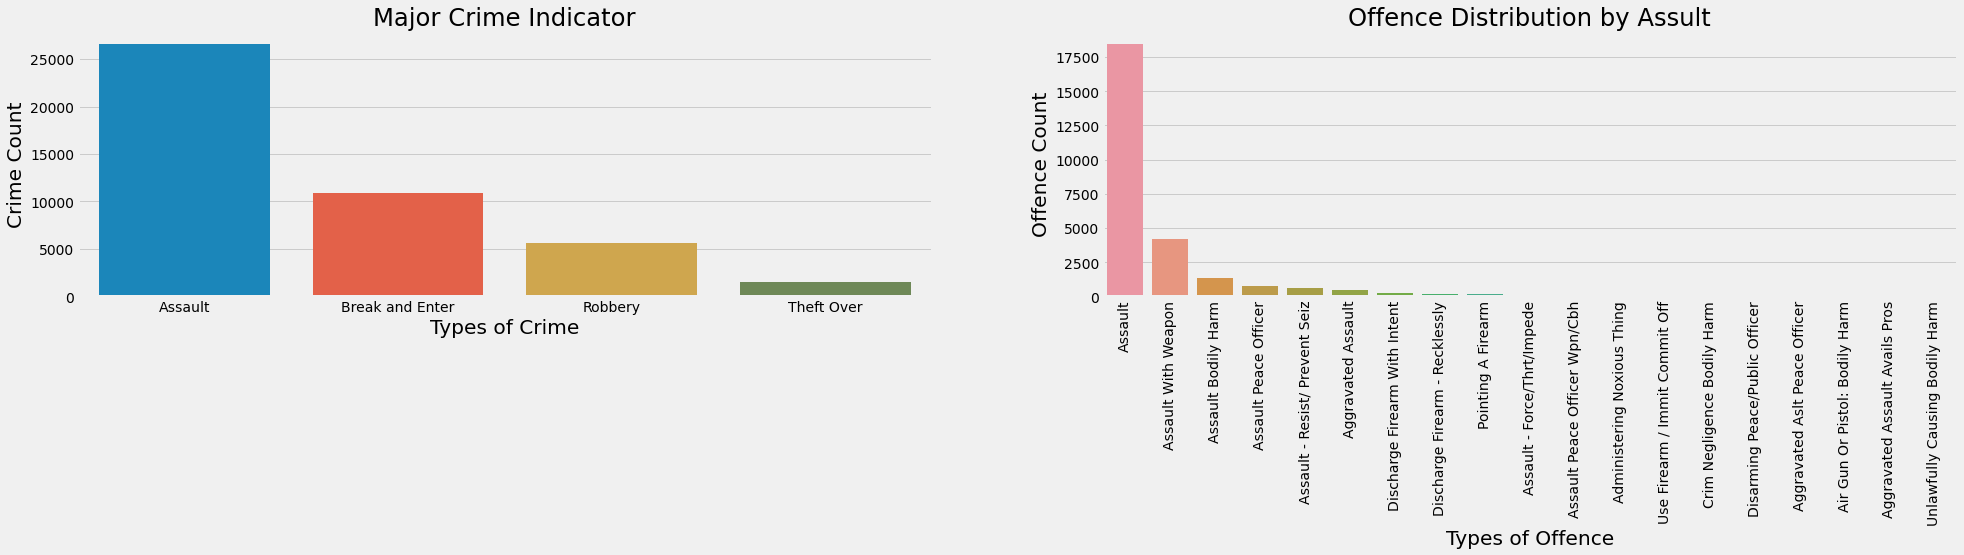

In [ ]:
plt.figure(figsize=(30,10))
MCI= df.groupby('MCI',as_index=False).size()
assaultTypes= df[df.MCI=='Assault'].groupby('offence', as_index=False).size()
autoTheftTypes= df[df.MCI=='Auto Theft'].groupby('offence', as_index=False).size()

plt.subplot(221)
sns.barplot(x='MCI', y='size', data=MCI.sort_values(by='size', ascending=False))
plt.title('Major Crime Indicator', fontsize='xx-large')
plt.xlabel('Types of Crime', fontsize='x-large')
plt.ylabel('Crime Count', fontsize='x-large')

plt.subplot(222)
sns.barplot(x='offence', y='size', data=assaultTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Assult', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.show()

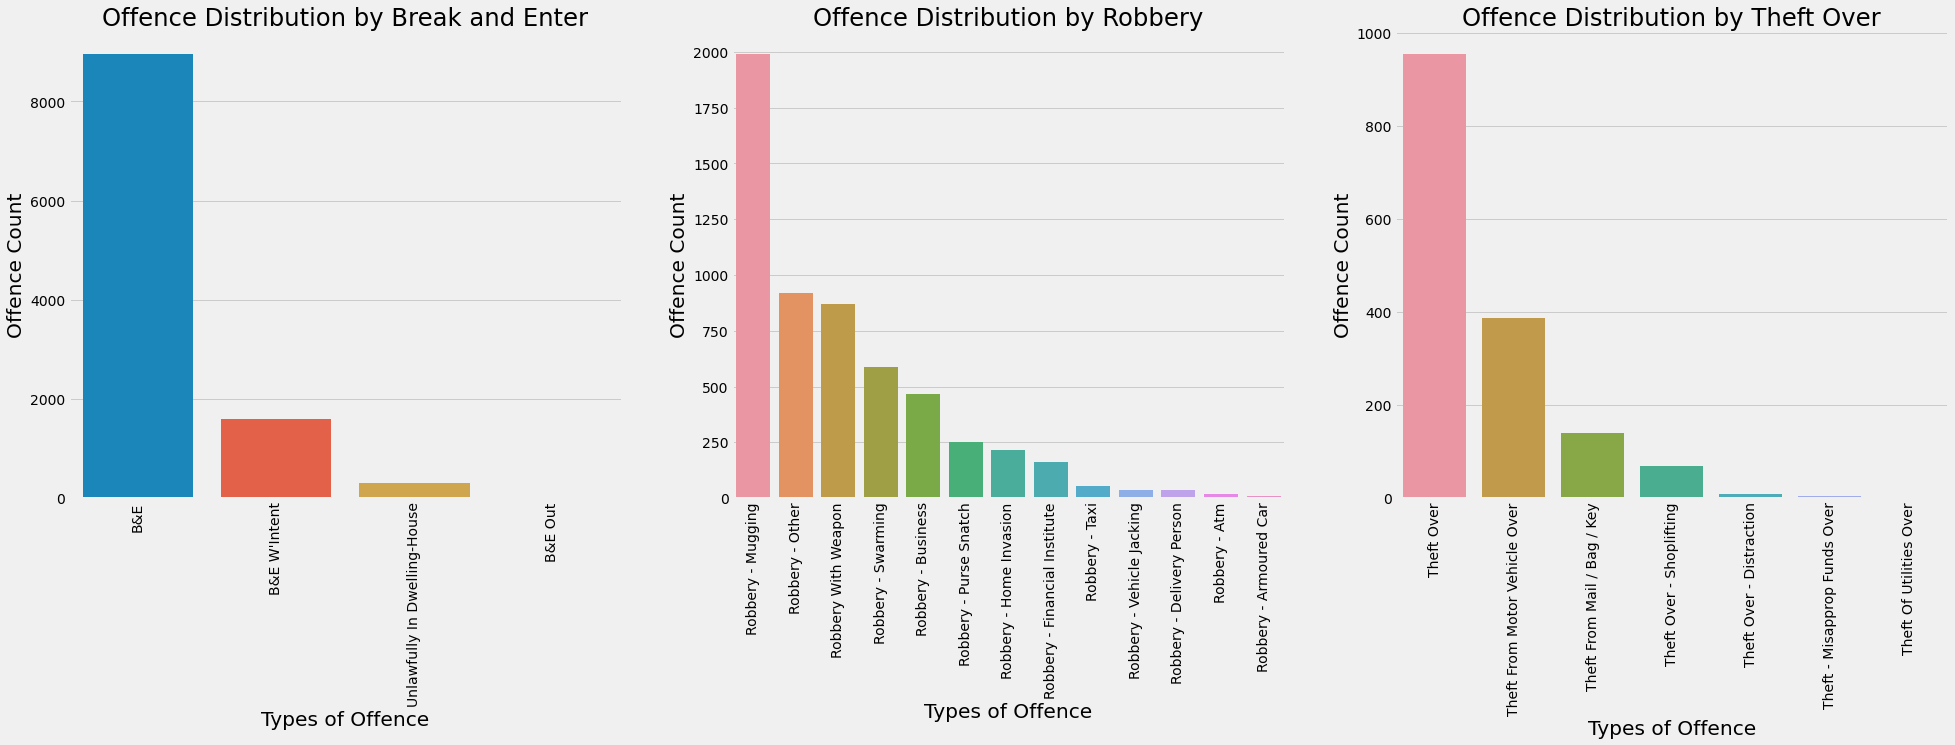

In [ ]:
plt.figure(figsize=(30,8))

breakEnterTypes= df[df.MCI=='Break and Enter'].groupby('offence', as_index=False).size()
robberyTypes= df[df.MCI=='Robbery'].groupby('offence', as_index=False).size()
theftOverTypes= df[df.MCI=='Theft Over'].groupby('offence', as_index=False).size()

plt.subplot(131)
sns.barplot(x='offence', y='size', data=breakEnterTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Break and Enter', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(132)
sns.barplot(x='offence', y='size', data=robberyTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Robbery', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(133)
sns.barplot(x='offence', y='size', data=theftOverTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Theft Over', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.show()

In [ ]:
df.reporteddate= pd.to_datetime(df.reporteddate)
df['reportOnlyDate']= df.reporteddate.dt.date
df.occurrencedate= pd.to_datetime(df.occurrencedate)
df['occurrenceOnlyDate']= df.occurrencedate.dt.date
df['delayInReporting']= (df.reportOnlyDate - df.occurrenceOnlyDate).dt.days

# **Time Series Forcasting** Problem and Multipath Approach
## Time Series Analysis for **Total Crime Count**

In [ ]:
df['count']= 1
mci_monthwise = df.groupby(['occurrenceday','MCI'],as_index=False).agg({'count':'sum'})

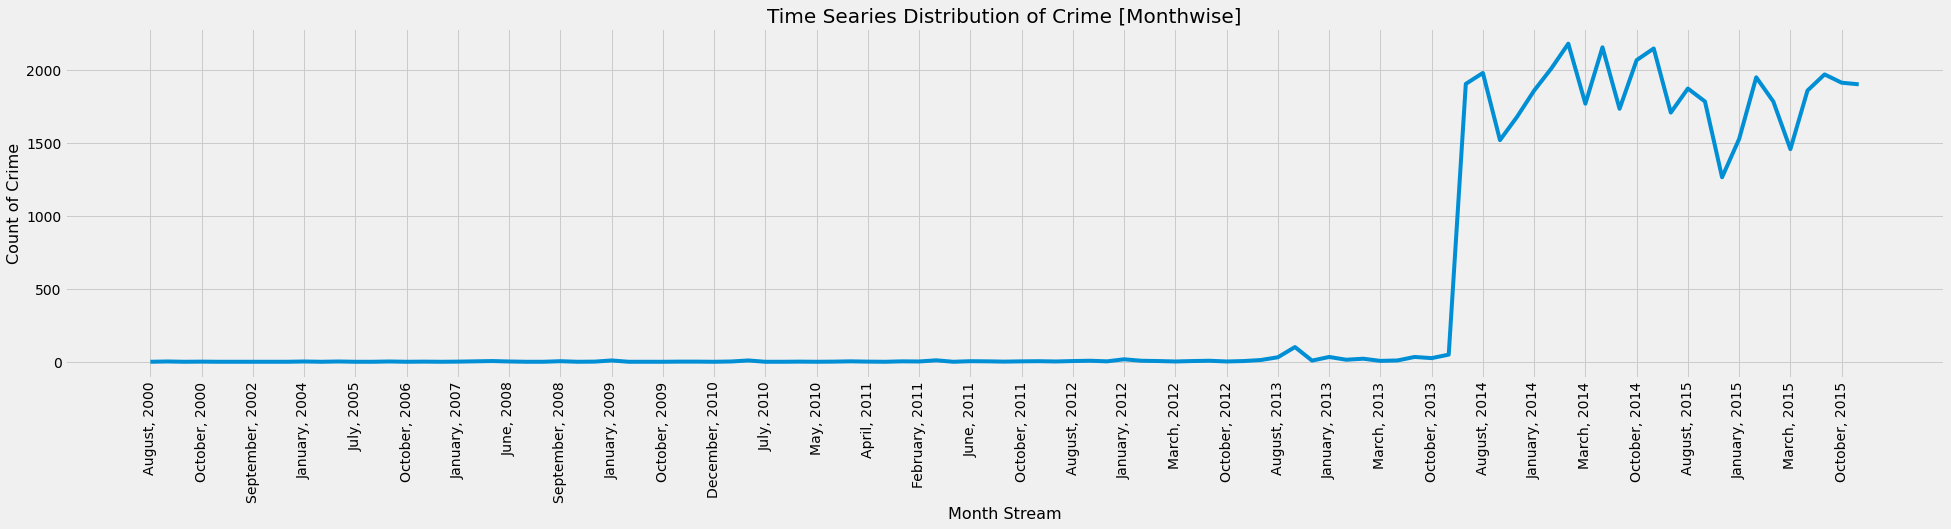

In [ ]:
mci_distribution = df.groupby(['occurrenceyear','occurrencemonth'],as_index=False).agg({'count':'sum'})
mci_distribution['occurrenceyear']= mci_distribution['occurrenceyear'].astype('int').astype('str')
mci_distribution['monthYear']= mci_distribution['occurrencemonth'] +', '+ mci_distribution['occurrenceyear']

plt.grid('on')
plt.plot(mci_distribution['monthYear'], mci_distribution['count'])
plt.xlabel('Month Stream')
plt.ylabel('Count of Crime')
plt.title('Time Searies Distribution of Crime [Monthwise]')
plt.xticks(np.arange(0, mci_distribution['monthYear'].shape[0], 3), rotation=90)
plt.show()

In [ ]:
occuranceDateVsMciCount= df.groupby(['occurrenceOnlyDate','MCI'],as_index=False).agg({'count':'sum'})
trimmedOccuranceDateVsMciCount= occuranceDateVsMciCount[occuranceDateVsMciCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]

In [ ]:
# occuranceDateCount= df.groupby(['occurrenceOnlyDate'],as_index=False).agg({'count':'sum'})
occuranceDateCount= df.groupby('occurrenceOnlyDate')['count'].sum().reset_index()
trimmedOccuranceDateCount= occuranceDateCount[occuranceDateCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]
trimmedOccuranceDateCount['occurrenceOnlyDate']= pd.to_datetime(trimmedOccuranceDateCount.occurrenceOnlyDate)
trimmedOccuranceDateCount.set_index('occurrenceOnlyDate', inplace=True)

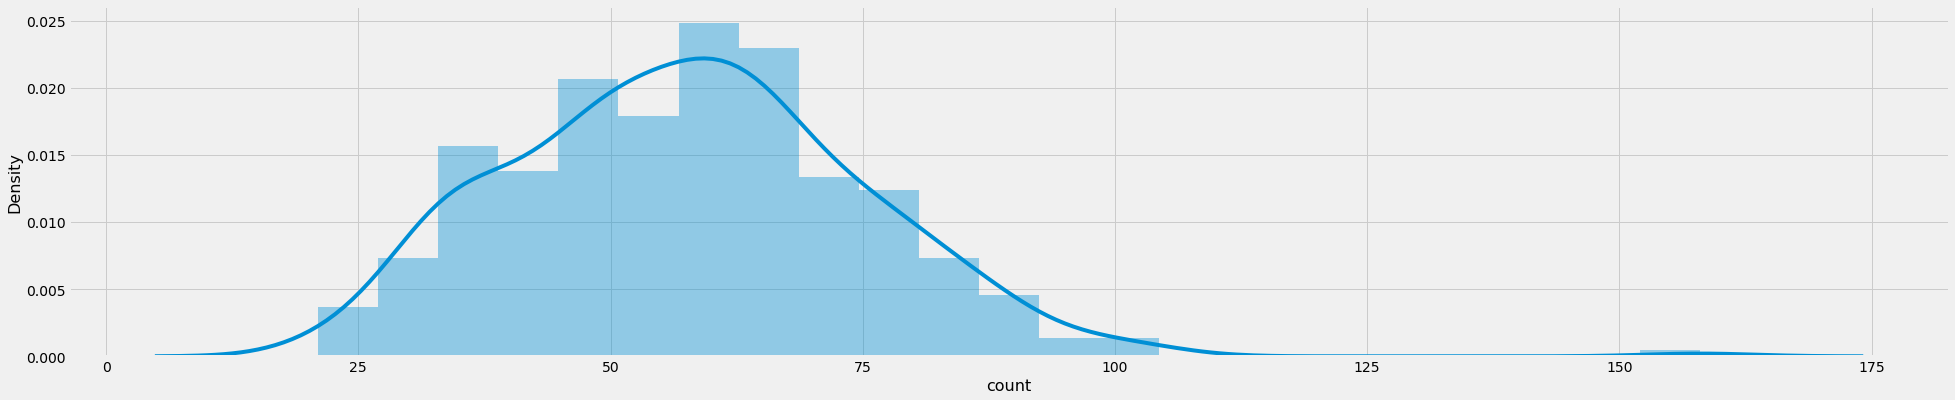

In [ ]:
sns.distplot(trimmedOccuranceDateCount['count'])
plt.show()
     

In [ ]:
trainData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index < pd.to_datetime('2018-12-31')]
testData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')]

y= trimmedOccuranceDateCount['count'].resample('MS').mean()

## **SARIMA** Time Series Forcasting

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

resultDict= dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod= sm.tsa.statespace.SARIMAX(trainData, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            resultDict['ARIMA{}x{}12'.format(param, param_seasonal)]= results.aic
        except:
            continue

minIndexARIMA= list(resultDict.keys())[(list(resultDict.values()).index(min(resultDict.values())))]
print('MIN INDEX: {}'.format(minIndexARIMA))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4012.2992565607597
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3630.301444981341
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3211.6208297668645
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2906.7846133134917
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3234.463114325224
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3004.4968047338925
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2999.5172713931406
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2908.470895185782
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3678.3447433403703
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3406.1415147431644
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3179.791409729653
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2875.142410607033
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3203.242434825542
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2974.516299848575
ARIMA(0, 0, 1)x(1, 1, 0, 1

In [ ]:
crimeforecast=results.forecast(steps=365)[0]
testData

,count
occurrenceOnlyDate,


In [ ]:
SARIMAXmodel= sm.tsa.statespace.SARIMAX(trainData, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
SARIMAXresults= SARIMAXmodel.fit()
print(SARIMAXresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2037      0.054      3.740      0.000       0.097       0.310
ma.L1         -0.9669      0.023    -42.793      0.000      -1.011      -0.923
ma.S.L12      -1.0001     41.525     -0.024      0.981     -82.387      80.387
sigma2       239.4685   9948.149      0.024      0.981   -1.93e+04    1.97e+04


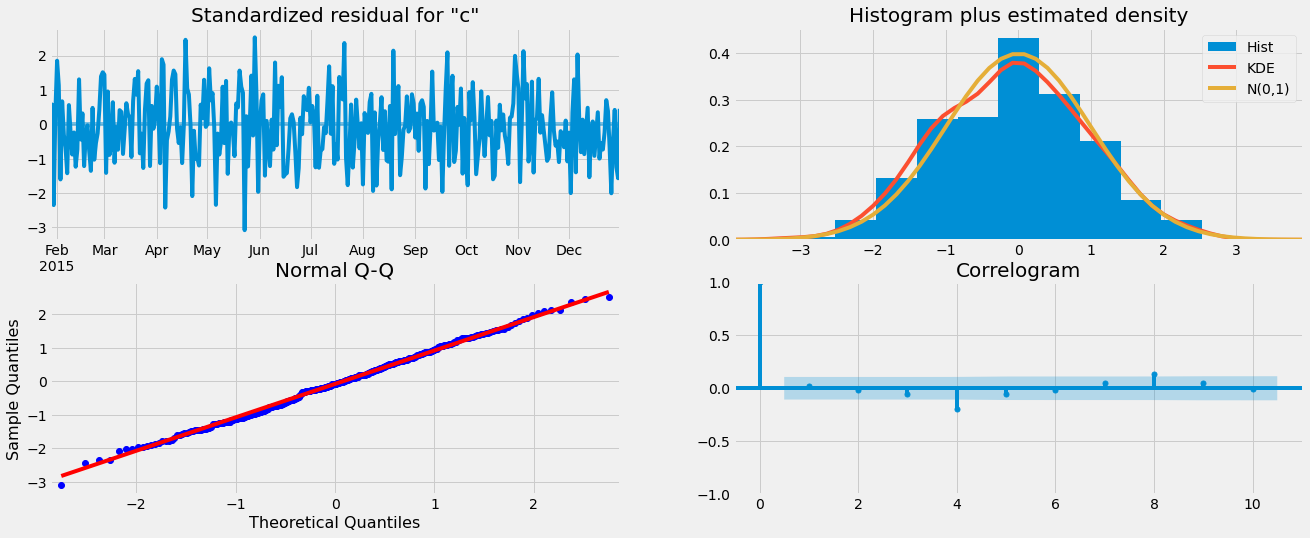

In [ ]:
SARIMAXresults.plot_diagnostics(figsize=(20, 8))
plt.show()

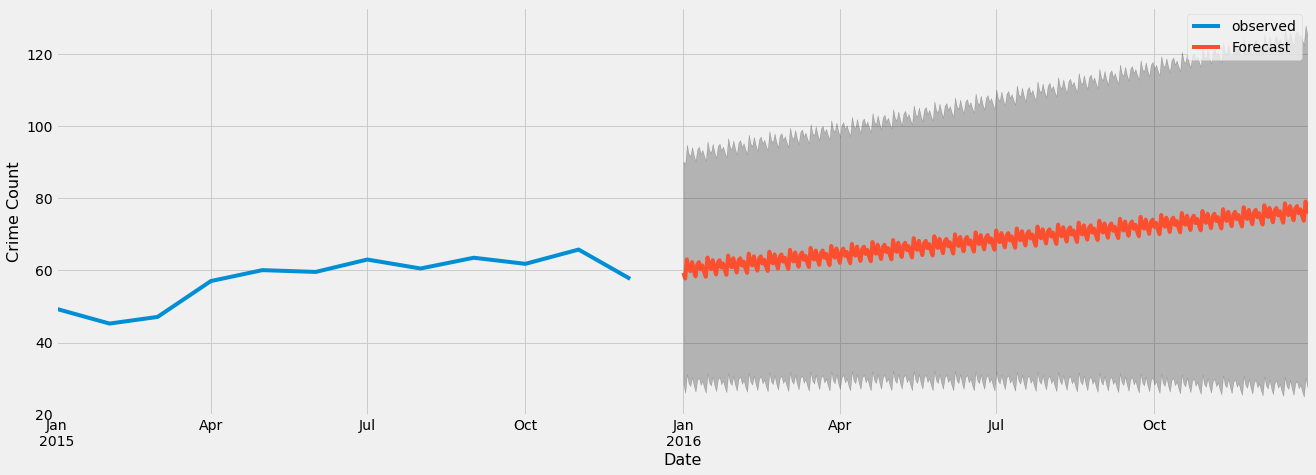

In [ ]:
pred_uc= SARIMAXresults.get_forecast(steps=365)
pred_ci= pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()

In [ ]:
testData['predValues']= pred_uc.predicted_mean.astype('int')

testData['lowerCount']= pred_ci[pred_ci.index >= testData.index.min()]['lower count']
testData['upperCount']= pred_ci[pred_ci.index >= testData.index.min()]['upper count']

mse= round(((testData['count'] - testData['predValues'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((testData['upperCount'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((testData['lowerCount'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(testData.head())

Mean Square Error: nan
Root Mean Square Error: nan
Mean Square Error with Upper Envelop: nan
Root Mean Square Error with Upper Envelop: nan
Mean Square Error with Lower Envelop: nan
Root Mean Square Error with Lower Envelop: nan

                    count  predValues  lowerCount  upperCount
occurrenceOnlyDate                                           
2016-01-01            NaN          59   28.463202   90.145768
2016-01-02            NaN          57   26.044155   89.439501
2016-01-03            NaN          63   31.237579   94.832783
2016-01-04            NaN          60   28.692445   92.361712
2016-01-05            NaN          59   27.929552   91.654630


## **Prophet** Time Series

In [ ]:
trimmedOccuranceDateCountProphetFit= trainData.reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
prophet_model= Prophet(daily_seasonality=True)
prophet_model.fit(trimmedOccuranceDateCountProphetFit)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9p8i1ylv/t7s_0uhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9p8i1ylv/bc8w6kma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31286', 'data', 'file=/tmp/tmp9p8i1ylv/t7s_0uhz.json', 'init=/tmp/tmp9p8i1ylv/bc8w6kma.json', 'output', 'file=/tmp/tmp9p8i1ylv/prophet_model523maot8/prophet_model-20230226103623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:36:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:36:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
prophetForecast= prophet_model.make_future_dataframe(periods=365)
prophetForecast= prophet_model.predict(prophetForecast)

<Figure size 1296x432 with 0 Axes>

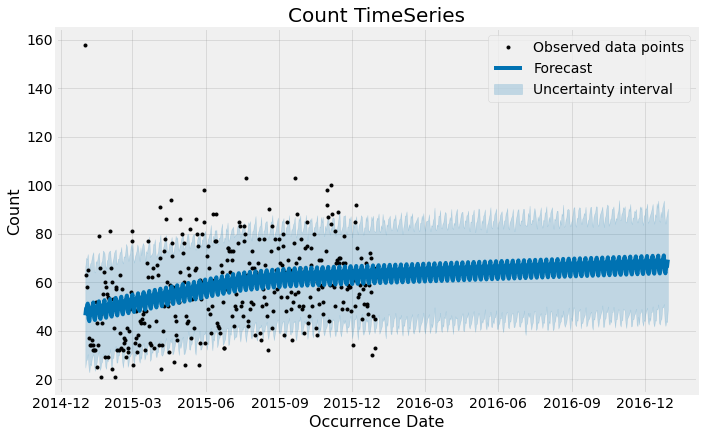

In [ ]:
plt.figure(figsize=(18, 6))
prophet_model.plot(prophetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.legend()
plt.title('Count TimeSeries');
     

In [ ]:
prophetForcast_yhat= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
prophetForcast_trend= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['trend', 'trend_lower', 'trend_upper']]
for _ in tqdm(prophetForcast_yhat.columns):
  prophetForcast_yhat[_]= prophetForcast_yhat[_].astype('int')
for _ in tqdm(prophetForcast_trend.columns):
  prophetForcast_trend[_]= prophetForcast_trend[_].astype('int')
     

100%|██████████| 3/3 [00:00<00:00, 1256.91it/s]


In [ ]:
mse= round(((testData['count'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete yHat Data Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(prophetForcast_yhat.head())
     

Prophet Complete yHat Data Error Analysis

Mean Square Error: nan
Root Mean Square Error: nan
Mean Square Error with Upper Envelop: nan
Root Mean Square Error with Upper Envelop: nan
Mean Square Error with Lower Envelop: nan
Root Mean Square Error with Lower Envelop: nan

Empty DataFrame
Columns: [yhat, yhat_lower, yhat_upper]
Index: []


In [ ]:
mse= round(((testData['predValues'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['upperCount'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['lowerCount'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis

Mean Square Error: nan
Root Mean Square Error: nan
Mean Square Error with Upper Envelop: nan
Root Mean Square Error with Upper Envelop: nan
Mean Square Error with Lower Envelop: nan
Root Mean Square Error with Lower Envelop: nan


ValueError: ignored

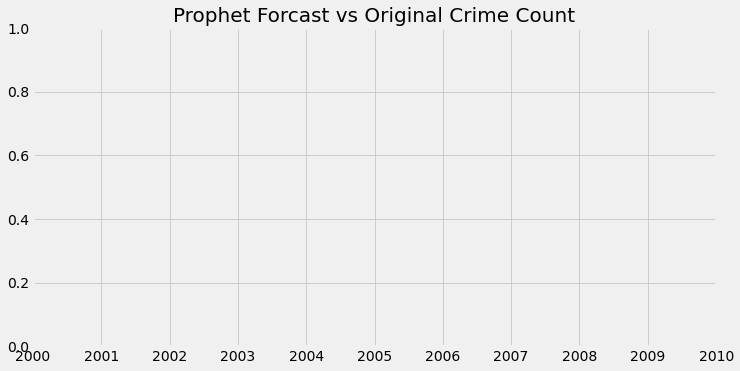

In [ ]:
plt.rcParams['figure.figsize']= 24, 12

plt.subplot(221)
plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count')
plt.plot(prophetForcast_yhat.index, testData['count'].iloc[:-1], lw=1)
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1, marker='+')
plt.fill_between(prophetForcast_yhat.index, prophetForcast_yhat['yhat_upper'], prophetForcast_yhat['yhat_lower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])


plt.subplot(222)
plt.grid('on')
plt.title('ARIMA Forcast vs Original Crime Count')
plt.plot(testData.index, testData['count'], lw=1)
plt.plot(testData.index, testData['predValues'], lw=1, marker='+')
plt.fill_between(testData.index, testData['upperCount'], testData['lowerCount'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'ARIMA yHat', 'Potential Envelop'])

plt.subplot(223)
plt.grid('on')
plt.title('ARIMA Forcast vs Prophet Forcast')
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1)
plt.plot(testData.index[:-1], testData['predValues'][:-1], lw=1)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Prophet Forcast', 'ARIMA Forcast'])

plt.show()

In [ ]:
print('Different Major Crime Indicators', end='\n\n')
for i, _ in enumerate(np.unique(df.MCI)):
  print('{}. {}'.format(i, _))

  mciDifferedResult= pd.DataFrame()

Different Major Crime Indicators



TypeError: ignored

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9p8i1ylv/jsix9usx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9p8i1ylv/cp3djkxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71727', 'data', 'file=/tmp/tmp9p8i1ylv/jsix9usx.json', 'init=/tmp/tmp9p8i1ylv/cp3djkxu.json', 'output', 'file=/tmp/tmp9p8i1ylv/prophet_modeln4qzgyyt/prophet_model-20230226104115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:41:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:41:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


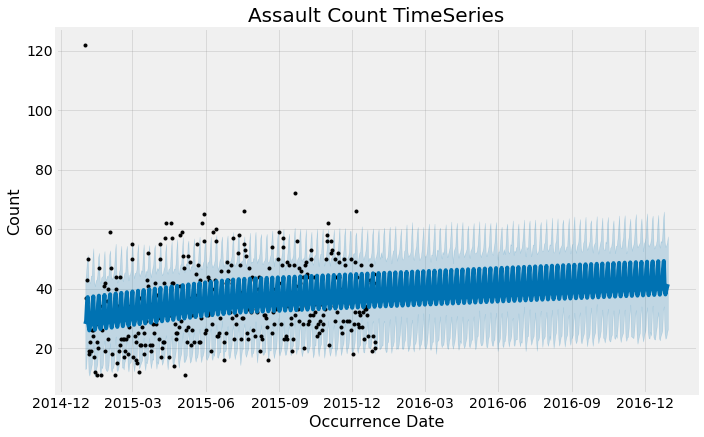

In [ ]:
assaultTimewiseData= df[df.MCI == 'Assault'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
assaultTimewiseData= assaultTimewiseData[assaultTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  assaultTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

assaultProphetModel= Prophet(daily_seasonality=True).fit(assaultTimewiseData[assaultTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
assaultProphetForecast= assaultProphetModel.make_future_dataframe(periods=365)
assaultProphetForecast= assaultProphetModel.predict(assaultProphetForecast)

assaultProphetModel.plot(assaultProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Assault Count TimeSeries');

In [ ]:
comparableData= assaultTimewiseData[assaultTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= assaultProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= assaultProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= assaultProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['Assault']= comparableData.yhat
mciDifferedResult['lower']= comparableData.yhatLower
mciDifferedResult['upper']= comparableData.yhatUpper

plt.rcParams['figure.figsize']= 12,6

plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()
     

NameError: ignored

In [ ]:
autoTheftTimewiseData= df[df.MCI == 'Auto Theft'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
autoTheftTimewiseData= autoTheftTimewiseData[autoTheftTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  autoTheftTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

autoTheftProphetModel= Prophet(daily_seasonality=True).fit(autoTheftTimewiseData[autoTheftTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
autoTheftProphetForecast= autoTheftProphetModel.make_future_dataframe(periods=365)
autoTheftProphetForecast= autoTheftProphetModel.predict(autoTheftProphetForecast)


autoTheftProphetModel.plot(autoTheftProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Auto Theft Count TimeSeries');

ValueError: ignored

In [ ]:
comparableData= autoTheftTimewiseData[autoTheftTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= autoTheftProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= autoTheftProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= autoTheftProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['AutoTheft']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

NameError: ignored